In [2]:
"""
Zé Fonseca
31/01/2016
Simulate data that combines uncertainties in SNe classification, magnitude and redshift.  
"""

import numpy as np
import scipy as sp
from scipy.integrate import quad
import matplotlib.pyplot as plt
import sys

%matplotlib inline

In [3]:
#cosmological functions
#general functions

def invH(z,OM,w):
    return (OM*(1+z)**3+(1-OM)*(1+z)**(3*(w+1)))**(-.5)
   
c=2.99792e5

def mu(z,OM,H0,w):
    if type(z)=='float' or type(z)=='int':
        return 5*np.log10((1+z)/H0*c*quad(invH,0,z,args=(OM,w))[0])+25
    else:
        dl=[]
        for i in range(len(z)):
            dl.append(quad(invH,0,z[i],args=(OM,w))[0])
        return 5*np.log10(np.array(dl)*(1+z)*c/H0)+25

In [28]:
z_max=1.0
z_min=0.015
N=1000
z=np.random.rand(N)*(z_max-z_min)+z_min
z.sort()
mu_t=mu(z,0.31,67.74,-1)
SNe=np.random.rand(N)
b=np.zeros(N)
sig_mu=np.zeros(N)
Ia=[]
nonIa=[]
for i in range(N):
    if SNe[i]<0.25:
        sig_mu[i]=0.2
        Ia.append(i)
    else:
        sig_mu[i]=1.5
        b[i]=2.0
        nonIa.append(i)
mu_o=np.random.randn(N)*sig_mu+mu_t+b
        

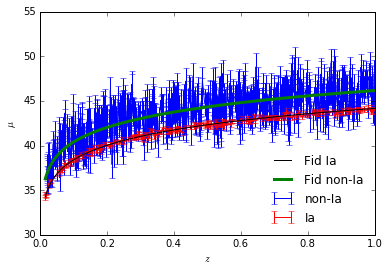

In [35]:
plt.errorbar(z[nonIa],mu_o[nonIa],yerr=[sig_mu[nonIa],sig_mu[nonIa]],label='non-Ia')
plt.errorbar(z[Ia],mu_o[Ia],yerr=[sig_mu[Ia],sig_mu[Ia]],color='r',ms=2,label='Ia')
plt.plot(z,mu_t,'k',label='Fid Ia')
plt.plot(z,mu_t+2,'g',label='Fid non-Ia',lw=3)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mu$')
plt.legend(loc=4,fontsize=12,frameon=False)
plt.savefig('sim_data_alltypes_nozuncertainty.pdf')
plt.show()

In [48]:
z_b21=z+np.random.randn(N)*0.04*(1+z)
index=np.argwhere(z_b21<0)
while len(index)>0:
    z_b21[index]=z[index]+np.random.randn(len(index))*0.04*(1+z[index])
    index=np.argwhere(z_b21<0)

/Users/Ze/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


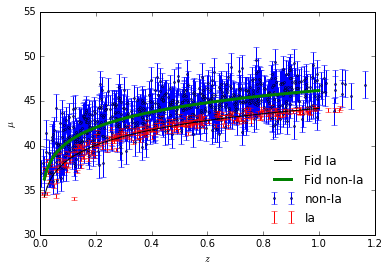

In [57]:
plt.errorbar(z_b21[nonIa],mu_o[nonIa],yerr=[sig_mu[nonIa],sig_mu[nonIa]],marker='o',ms=2,label='non-Ia',ls='')
plt.errorbar(z_b21[Ia],mu_o[Ia],yerr=[sig_mu[Ia],sig_mu[Ia]],color='r',ms=2,label='Ia',ls='')
plt.plot(z,mu_t,'k',label='Fid Ia')
plt.plot(z,mu_t+2,'g',label='Fid non-Ia',lw=3)
plt.xlabel(r'$z$')
plt.ylabel(r'$\mu$')
plt.legend(loc=4,fontsize=12,frameon=False)
plt.savefig('sim_data_alltypes_zuncertainty.pdf')
plt.show()

In [61]:
snetype=np.ones(N)
snetype[nonIa]=0
np.savetxt('fulldataset_zf.txt',np.c_[z,z_b21,mu_t,mu_o,snetype],fmt=['%2.3f']*4+['%1.f'],\
           header='\n'.join(["Error in z %.2f" %0.04,"Error in mu %.2f for Ia and %.2f for nonaIa" %(0.2,1.5),\
                             "Type=1 for Ia, 0 otherwise","z  z_shifted   mu_t   mu_o   type"]))